In [5]:
#!pip install tqdm
from collections import defaultdict, deque, Counter
import numpy as np
from tqdm import tqdm_notebook as tqdm 
import pandas as pd

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

# For plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
#!pip install ipympl
import ipympl

C:\ProgramData\Anaconda3\lib\site-packages\ipympl\__init__.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'nbAgg' by the following code:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\p

In [6]:
filename = "DATA/cheetah.cs.fiu.edu-110108-113008.3.blkparse"
df = pd.read_csv(filename, sep=' ',header = None)
df.columns = ['timestamp','pid','pname','blockNo', \
              'blockSize', 'readOrWrite', 'bdMajor', 'bdMinor', 'hash']
blocktrace = df['blockNo'].tolist()
len(blocktrace)

23374516

## Helper Functions

### Global  Variables

In [7]:
maxpos = 1000000000000

num_params = 3

cache_size = 1000 # default cache size
sampling_freq = cache_size # number of samples skipped
eviction = 1 


lruCorrect = 0
lruIncorrect = 0

lfuCorrect = 0
lfuIncorrect = 0


X = np.array([], dtype=np.int64).reshape(0,num_params)
Y = np.array([], dtype=np.int64).reshape(0,1)

In [8]:
def lruPredict(C,LRUQ,Y_OPT):
    global lruCorrect, lruIncorrect
    Y_current = []
    KV = defaultdict(int)
    for i in range(len(LRUQ)):
        KV[LRUQ[i]] = len(LRUQ) - i
    KV_sorted = Counter(KV)
    evict_dict = dict(KV_sorted.most_common(eviction))
    for e in C:
        if e in evict_dict:
            Y_current.append(1)
        else:
            Y_current.append(0)
    for i in range(len(Y_current)):
        if Y_current[i] is Y_OPT[i]:
            lruCorrect+=1
        else:
            lruIncorrect+=1
    return Y_current

# returns sequence of blocks in prioirty order

def Y_getBlockSeq(Y_pred_prob):
    x = []
    for i in range(len(Y_pred_prob)):
        x.append(Y_pred_prob[i][0])
    x = np.array(x)
    idx = np.argsort(x)
    idx = idx[:eviction]
    return idx


def Y_getMinPredict(Y_pred_prob):
    x = []
    for i in range(len(Y_pred_prob)):
        x.append(Y_pred_prob[i][0])
    x = np.array(x)
    idx = np.argpartition(x, eviction)
    
    Y_pred = np.zeros(len(Y_pred_prob), dtype=int)
    for i in range(eviction):
        Y_pred[idx[i]] = 1
    assert(Counter(Y_pred)[1] == eviction)
    return Y_pred


def lfuPredict(C,LFUDict,Y_OPT):
    global lfuCorrect, lfuIncorrect
    Y_current = []
    KV = defaultdict()
    for e in C:
        KV[e] = LFUDict[e]
    KV_sorted = Counter(KV)
    evict_dict = dict(KV_sorted.most_common(eviction))
    for e in C:
        if e in evict_dict:
            Y_current.append(1)
        else:
            Y_current.append(0)
    for i in range(len(Y_current)):
        if Y_current[i] is Y_OPT[i]:
            lfuCorrect+=1
        else:
            lfuIncorrect+=1
    return Y_current

# return "eviction" blocks that are being accessed furthest
# from the cache that was sent to us.

def getY(C,D):
    assert(len(C) == len(D))
    Y_current = []
    KV_sorted = Counter(D)
    evict_dict = dict(KV_sorted.most_common(eviction))
    assert(len(evict_dict) == eviction)
    all_vals = evict_dict.values()
    for e in C:
        if e in evict_dict.values():
            Y_current.append(1)
        else:
            Y_current.append(0)
    #print (Y_current.count(1))
    assert(Y_current.count(1) == eviction)
    assert((set(all_vals)).issubset(set(C)))
    return Y_current

def getLFURow(LFUDict, C):
    x_lfurow = []
    for e in C:
        x_lfurow.append(LFUDict[e])
    norm = x_lfurow / np.linalg.norm(x_lfurow)
    return norm
    
def getLRURow(LRUQ, C):
    x_lrurow = []
    KV = defaultdict(int)
    for i in range(len(LRUQ)):
        KV[LRUQ[i]] = i
    for e in C:
        x_lrurow.append(KV[e])
    norm = x_lrurow / np.linalg.norm(x_lrurow)
    return norm

def normalize(feature, blocks):
    x_feature = []
    for i in range(len(blocks)):
        x_feature.append(feature[blocks[i]])
    return x_feature / np.linalg.norm(x_feature)

def getX(LRUQ, LFUDict, C):
#def getX(LRUQ, LFUDict, C, CacheTS, CachePID):   
    X_lfurow = getLFURow(LFUDict, C)
    X_lrurow = getLRURow(LRUQ, C)
    X_bno    = C / np.linalg.norm(C)
#     X_ts     = normalize(CacheTS, C)
#     X_pid    = normalize(CachePID, C)
    return (np.column_stack((X_lfurow, X_lrurow, X_bno)))
    
    
def populateData(LFUDict, LRUQ, C, D):
#def populateData(LFUDict, LRUQ, C, D, CacheTS, CachePID):
    global X,Y
    C = list(C)
    Y_current = getY(C, D)
    #X_current = getX(LRUQ, LFUDict, C, CacheTS, CachePID)
    X_current = getX(LRUQ, LFUDict, C)

    Y = np.append(Y, Y_current)
    X = np.concatenate((X,X_current))
    assert(Y_current.count(1) == eviction)
    return Y_current

In [9]:
def belady_opt(blocktrace, frame):
    global maxpos
    
    OPT = defaultdict(deque)
    D = defaultdict(int)
    LFUDict = defaultdict(int)
    LRUQ = []
    #CacheTS = defaultdict(int)
    #CachePID = defaultdict(int)

    for i, block in enumerate(tqdm(blocktrace, desc="OPT: building index")):
        OPT[block].append(i)

    hit, miss = 0, 0

    C = []
    #count=0
    #seq_number = 0
    for seq_number, block in enumerate(tqdm(blocktrace, desc="OPT")):
#    for block in blocktrace: 
        LFUDict[block] +=1

        if len(OPT[block]) is not 0 and OPT[block][0] == seq_number:
            OPT[block].popleft()
        #CacheTS [blocktrace[seq_number]] = timestamp[seq_number]
        #CachePID [blocktrace[seq_number]] = pid[seq_number]
        if block in C:
            hit+=1
            LRUQ.remove(block)
            LRUQ.append(block)
            assert( seq_number in D)
            del D[seq_number]
            if len(OPT[block]) is not 0:
                D[OPT[block][0]] = block
                OPT[block].popleft()
            else:
                D[maxpos] = block
                maxpos -= 1
        else:
            miss+=1
            if len(C) == frame:
                assert(len(D) == frame)
                evictpos = max(D)
                
                if (seq_number % sampling_freq +1 == sampling_freq):
                    #Y_OPT = populateData(LFUDict, LRUQ, C, D, CacheTS, CachePID)
                    Y_OPT = populateData(LFUDict, LRUQ, C, D)
                    lruPredict(C,LRUQ,Y_OPT)
                    lfuPredict(C,LFUDict,Y_OPT)
                
                C[C.index(D[evictpos])] = block
                LRUQ.remove(D[evictpos])
                #del CacheTS [D[evictpos]]
                #del CachePID [D[evictpos]]
                del D[evictpos]
            else:
                C.append(block)
                
            if len(OPT[block]) is not 0:
                D[OPT[block][0]] = block
                OPT[block].popleft()
            else:
                D[maxpos] = block
                maxpos -= 1
            LRUQ.append(block)


    hitrate = hit / (hit + miss)
    #print(hitrate)
    return hitrate

In [10]:
belady_opt(blocktrace, 1000)

0.08938636419252488

In [11]:
X.shape

(21246000, 3)

In [12]:
Y.shape

(21246000,)

In [13]:
Xevic=X[np.where(Y==1)]

In [14]:
Xret=X[np.where(Y==0)]

<IPython.core.display.Javascript object>


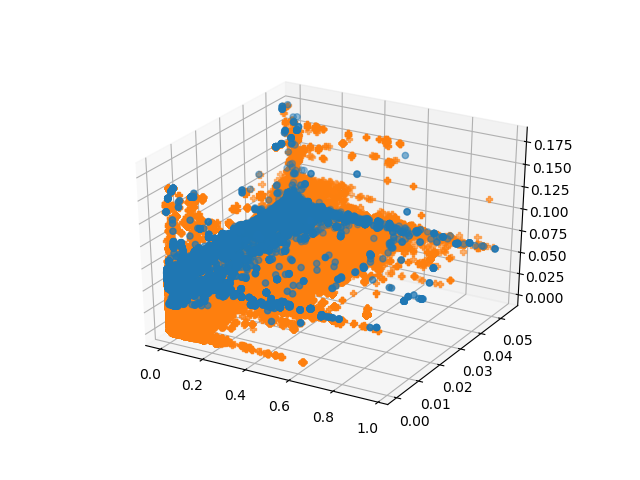

In [15]:
fig = plt.figure()
ax = fig.gca(projection='3d')
'''
I have assumed here some labels randomly; Red markers represent evicted block with five featrues and blue markers
represent retained blocks in the cache. This graph can be used to show that why clustering is difficult/easy in our data. 

'''
ax.scatter(Xevic[:,0], Xevic[:,1], Xevic[:,2],marker="o")
ax.scatter(Xret[:,0], Xret[:,1], Xret[:,2],marker="P")

In [ ]:
Xevic

In [3]:
plt.scatter(Xevic[:,0], Xevic[:,1],marker="o")
plt.scatter(Xret[:,0], Xret[:,1],marker="P")

NameError: name 'Xevic' is not defined

# 2nd Plotting

In [12]:
# def belady_opt(blocktrace, frame):
#     '''
#     INPUT
#     ==========
#     blocktrace = list of block request sequence
#     frame = size of the cache
    
#     OUTPUT
#     ==========
#     hitrate 
#     '''
#     infinite_index = 10000 * len(blocktrace) # should be a large integer
    
#     block_index = defaultdict(deque) 
#     # dictionary with block number as key and list
#     # of index value in blocktrace
    
#     upcoming_index = defaultdict(int)
#     # dictionary with index number as key and value as block
    
#     frequency = defaultdict(int)
#     # dictionary of block as key and number
#     # of times it's been requested so far
    
#     recency = list()
#     # list of block in order of their request
    
#     Cache = deque()
#     # Cache with block
    
#     dataset = np.array([]).reshape(0,3*frame+1)
#     #columns represents the number of block in cache and 
#     #3 is the number of features such as frequency, recency and block number
#     #+1 is for label 0-1
    
#     d3_fin=np.array([]).reshape(0,3)
#     label_fin=np.array([]).reshape(0,1)
    
#     hit, miss = 0, 0
    
#     # populate the block_index
#     for i, block in enumerate(tqdm(blocktrace, \
#                               desc="buidling index", leave=False)):
#         block_index[block].append(i)
        
#     # sequential block requests start
#     for i, block in enumerate(tqdm(blocktrace, desc="sequence", leave=False)):
        
#         # increament the frequency number for the block
#         frequency[block] += 1
        
#         # make sure block has the value in block_index dictionary 
#         # as current seq_number
#         if len(block_index[block]) != 0 and block_index[block][0] == i:
            
#             # if yes, remove the first element of block_index[block]
#             block_index[block].popleft()
        
#         # if block exist in current cache
#         if block in Cache:
            
#             # increment hit
#             hit += 1
            
#             # update the recency
#             recency.remove(block)
#             recency.append(block)
            
#             # update upcoming_index
#             if i in upcoming_index:
                
#                 # delete old index
#                 del upcoming_index[i]
        
#                 if len(block_index[block]) is not 0:
#                     # add new upcoming index
#                     upcoming_index[block_index[block][0]] = block
#                     # remove index from block_index
#                     block_index[block].popleft()
#                 else:
#                     # add a large integer as index
#                     upcoming_index[infinite_index] = block
#                     # increament large integer
#                     infinite_index-=1
           
#         # block not in current cache
#         else:
            
#             # increament miss
#             miss += 1
            
#             # if cache has no free space
#             if len(Cache) == frame:
                
                
#                 # evict the farthest block in future request from cache
#                 if len(upcoming_index) != 0:
                    
#                     # find the farthest i.e. max_index in upcoming_index
#                     max_index = max(upcoming_index)
                    
#                     if (i % 1000 +1 == 1000):
#                         blockNo = np.array([i for i in Cache])
#                         blockNo = blockNo / np.linalg.norm(blockNo)
#                         recency_ = np.array([recency.index(i) for i in Cache])
#                         recency_ = recency_ / np.linalg.norm(recency_)
#                         frequency_ = np.array([frequency[i] for i in Cache])
#                         frequency_ = frequency_ / np.linalg.norm(frequency_)
#                         # For plotting (Below 2 lines)
#                         d3=np.column_stack((blockNo, recency_, frequency_))
#                         d3_fin=np.vstack((d3_fin, d3))
#                         # For plotting (Above 2 lines)
#                         stack = np.column_stack((blockNo, recency_, frequency_)).reshape(1,frame*3)
#                         stack = np.append(stack, Cache.index(upcoming_index[max_index]))
                        
#                         # For plotting (Cache configuration- below 2 lines)
#                         Cache_temp=list(Cache)
#                         # Yeh barabar ho jata hain 1 se replace
#                         Cache_temp[Cache_temp.index(upcoming_index[max_index])]=[1 for item in Cache_temp if item == \
#                                                                                  upcoming_index[max_index]][0] # Evicted blocks
#                         Cache_temp[Cache_temp.index(upcoming_index[max_index])]=[0 for item in Cache_temp if item != \
#                                                                                  upcoming_index[max_index]][0]
#                         # Yeh replacement with zero barabar nahi ho raha hain
#                         Cache_temp[int(0) for item in Cache_temp if item != upcoming_index[max_index]] # Retained blocks
#                         label_fin=np.append(label_fin, Cache_temp)
#                         # For plotting (Cache configuration- above 2 lines)
#                         print(Cache_temp)
#                         break
#                         dataset = np.vstack((dataset, stack))
#                     # remove the block with max_index from cache
#                     Cache.remove(upcoming_index[max_index])
                    
#                     # remove the block with max_index from recency dict
#                     recency.remove(upcoming_index[max_index])
                    
#                     # remove max_index element from upcoming_index
#                     del upcoming_index[max_index]
                    
#             # add upcoming request of current block in upcoming_index
#             if len(block_index[block]) != 0:
                
#                 # add upcoming index of block
#                 upcoming_index[block_index[block][0]] = block
               
#                 # remove the index from block_index 
#                 block_index[block].popleft()
            
#             else:
                
#                 # add a large integer as index
#                 upcoming_index[infinite_index] = block
                
#                 # increament high number
#                 infinite_index -= 1
                
                
            
#             # add block into Cache
#             Cache.append(block)
            
#             # add block into recency
#             recency.append(block)
            
            
#     # calculate hitrate
#     hitrate = hit / (hit + miss)

#     return hitrate, dataset,d3_fin,label_fin

In [13]:
# hitrate, dataset,D3,label = belady_opt(blocktrace, 1000)

In [60]:
label.shape

(1240,)

In [24]:
label[:1000]

array([4.88846200e+08, 0.00000000e+00, 5.08455712e+08, 5.08455720e+08,
       5.08500288e+08, 5.08500296e+08, 5.08500304e+08, 5.08516672e+08,
       5.08516680e+08, 5.08516688e+08, 3.95126368e+08, 1.00000000e+00,
       2.83196456e+08, 2.83196464e+08, 2.83196472e+08, 2.83196480e+08,
       2.83196488e+08, 2.83196496e+08, 2.83196504e+08, 2.83196512e+08,
       2.83196520e+08, 2.83196528e+08, 2.83196536e+08, 2.83196544e+08,
       2.83196552e+08, 2.83196560e+08, 2.83196568e+08, 2.83196576e+08,
       2.83196584e+08, 2.83196592e+08, 2.83196600e+08, 2.83196608e+08,
       2.83196616e+08, 2.83196624e+08, 2.83196632e+08, 2.83196640e+08,
       2.83196648e+08, 2.83196656e+08, 2.83196664e+08, 2.83196672e+08,
       2.83196680e+08, 2.83196688e+08, 2.83196696e+08, 2.83196704e+08,
       2.83196712e+08, 2.83196720e+08, 2.83196728e+08, 2.83196736e+08,
       2.83196744e+08, 2.83196752e+08, 2.83196760e+08, 2.83196768e+08,
       2.83196776e+08, 2.83196784e+08, 2.83196792e+08, 2.83196800e+08,
      

In [23]:
D3.shape

(1240000, 3)

In [17]:
X=D3[:1000,0]
Y=D3[:1000,1]
Z=D3[:1000,2]

# Plotting for Clustering

<IPython.core.display.Javascript object>


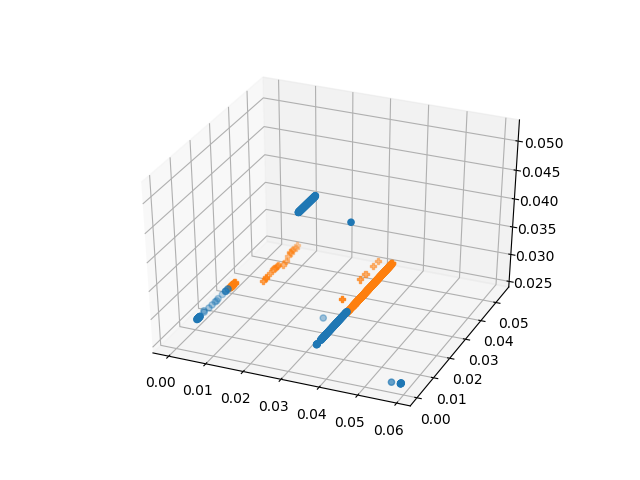

In [19]:
fig = plt.figure()
ax = fig.gca(projection='3d')
'''
I have assumed here some labels randomly; Red markers represent evicted block with five featrues and blue markers
represent retained blocks in the cache. This graph can be used to show that why clustering is difficult/easy in our data. 

We can also represent this while discussing k-NN. 

'''
ax.scatter(X[:500], Y[:500], Z[:500],marker="o")
ax.scatter(X[501:], Y[501:], Z[501:],marker="P")